# Machine Learning Pipeline - Should this be a challenge?

**[Big Data and Cloud Computing]**

## Group D
* Daniela Tomás, up202004946
* Diogo Nunes, up202007895
* Diogo Almeida, up202006059

## References
* https://mimic.mit.edu/docs/iii/tables/
* https://mit-lcp.github.io/mimic-schema-spy/relationships.html
* https://people.cs.pitt.edu/~jlee/note/intro_to_mimic_db.pdf
* https://stackoverflow.com/questions/59659344/how-to-process-faster-on-gz-files-in-spark-scala
* https://stackoverflow.com/questions/61961123/my-bar-plot-is-not-showing-bars-for-all-the-data-values

## PySpark Setup
Firstly, we import the necessary libraries, packages and methods.

In [71]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import min as spark_min, max as spark_max, avg as spark_avg, sum as spark_sum, round
from pyspark.sql.functions import col, desc
import os
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

import pandas as pd

Spark requires the JAVA_HOME environment variable to be set.

In [2]:
#os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-17-openjdk-amd64'
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-21-openjdk-21.0.3.0.9-1.fc40.x86_64/'
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'
os.environ['SPARK_MASTER_HOST'] = 'localhost'

Spark can be configured with lots of settings.  
In particular we highlight the "local[*]" which configures spark to run in standalone mode, so everything is running in the local machine, using all available threads.

In [3]:
spark = SparkSession.builder \
    .appName("ICU_Length_of_Stay_Prediction") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.host","127.0.0.1") \
    .config("spark.driver.bindAddress","127.0.0.1") \
    .getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/21 16:31:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Load the data stored in Parquet format.

In [4]:
file_path = "dataset/CHARTEVENTS.parquet"

df = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file_path)

df.printSchema()
df.show(5)

root
 |-- ROW_ID: integer (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- ITEMID: integer (nullable = true)
 |-- CHARTTIME: timestamp (nullable = true)
 |-- STORETIME: timestamp (nullable = true)
 |-- CGID: integer (nullable = true)
 |-- VALUE: string (nullable = true)
 |-- VALUENUM: double (nullable = true)
 |-- VALUEUOM: string (nullable = true)
 |-- WARNING: integer (nullable = true)
 |-- ERROR: integer (nullable = true)
 |-- RESULTSTATUS: string (nullable = true)
 |-- STOPPED: string (nullable = true)

+-------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
| ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+-------+----------+-------+----------+------+-------------------+-----------------

In [5]:
icu_file_path = "dataset/ICUSTAYS.parquet"

df_icustays = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(icu_file_path)

df_icustays.printSchema()
df_icustays.show(5)

root
 |-- ROW_ID: integer (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- DBSOURCE: string (nullable = true)
 |-- FIRST_CAREUNIT: string (nullable = true)
 |-- LAST_CAREUNIT: string (nullable = true)
 |-- FIRST_WARDID: integer (nullable = true)
 |-- LAST_WARDID: integer (nullable = true)
 |-- INTIME: timestamp (nullable = true)
 |-- OUTTIME: timestamp (nullable = true)
 |-- LOS: double (nullable = true)

+------+----------+-------+----------+--------+--------------+-------------+------------+-----------+-------------------+-------------------+------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|   LOS|
+------+----------+-------+----------+--------+--------------+-------------+------------+-----------+-------------------+-------------------+------+
|   365|       268| 110404|    280836| carev

In [6]:
d_icd_diagnoses_file_path = "dataset/D_ICD_DIAGNOSES.parquet"

df_d_icd_diagnoses = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(d_icd_diagnoses_file_path)

df_d_icd_diagnoses.printSchema()
df_d_icd_diagnoses.show(5)

root
 |-- ROW_ID: integer (nullable = true)
 |-- ICD9_CODE: string (nullable = true)
 |-- SHORT_TITLE: string (nullable = true)
 |-- LONG_TITLE: string (nullable = true)

+------+---------+--------------------+--------------------+
|ROW_ID|ICD9_CODE|         SHORT_TITLE|          LONG_TITLE|
+------+---------+--------------------+--------------------+
|   174|    01166|TB pneumonia-oth ...|Tuberculous pneum...|
|   175|    01170|TB pneumothorax-u...|Tuberculous pneum...|
|   176|    01171|TB pneumothorax-n...|Tuberculous pneum...|
|   177|    01172|TB pneumothorx-ex...|Tuberculous pneum...|
|   178|    01173|TB pneumothorax-m...|Tuberculous pneum...|
+------+---------+--------------------+--------------------+
only showing top 5 rows



In [7]:
patients_file_path = "dataset/PATIENTS.parquet"

df_patients = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(patients_file_path)

df_patients.printSchema()
df_patients.show(5)

root
 |-- ROW_ID: integer (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- GENDER: string (nullable = true)
 |-- DOB: timestamp (nullable = true)
 |-- DOD: timestamp (nullable = true)
 |-- DOD_HOSP: timestamp (nullable = true)
 |-- DOD_SSN: timestamp (nullable = true)
 |-- EXPIRE_FLAG: integer (nullable = true)

+------+----------+------+-------------------+-------------------+-------------------+-------+-----------+
|ROW_ID|SUBJECT_ID|GENDER|                DOB|                DOD|           DOD_HOSP|DOD_SSN|EXPIRE_FLAG|
+------+----------+------+-------------------+-------------------+-------------------+-------+-----------+
|   234|       249|     F|2075-03-13 00:00:00|               NULL|               NULL|   NULL|          0|
|   235|       250|     F|2164-12-27 00:00:00|2188-11-22 00:00:00|2188-11-22 00:00:00|   NULL|          1|
|   236|       251|     M|2090-03-15 00:00:00|               NULL|               NULL|   NULL|          0|
|   237|       252|     M|2

In [8]:
icd_diagnoses_file_path = "dataset/DIAGNOSES_ICD.parquet"

df_icd_diagnoses = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(icd_diagnoses_file_path)

df_icd_diagnoses.printSchema()
df_icd_diagnoses.show(5)

root
 |-- ROW_ID: integer (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- SEQ_NUM: integer (nullable = true)
 |-- ICD9_CODE: string (nullable = true)

+------+----------+-------+-------+---------+
|ROW_ID|SUBJECT_ID|HADM_ID|SEQ_NUM|ICD9_CODE|
+------+----------+-------+-------+---------+
|  1297|       109| 172335|      1|    40301|
|  1298|       109| 172335|      2|      486|
|  1299|       109| 172335|      3|    58281|
|  1300|       109| 172335|      4|     5855|
|  1301|       109| 172335|      5|     4254|
+------+----------+-------+-------+---------+
only showing top 5 rows



In [9]:
file_path = "dataset/ADMISSIONS.csv"

df_admissions = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("delimiter", ",") \
    .load(file_path)

df_admissions.printSchema()
df_admissions.show(5)

root
 |-- ROW_ID: integer (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- ADMITTIME: timestamp (nullable = true)
 |-- DISCHTIME: timestamp (nullable = true)
 |-- DEATHTIME: timestamp (nullable = true)
 |-- ADMISSION_TYPE: string (nullable = true)
 |-- ADMISSION_LOCATION: string (nullable = true)
 |-- DISCHARGE_LOCATION: string (nullable = true)
 |-- INSURANCE: string (nullable = true)
 |-- LANGUAGE: string (nullable = true)
 |-- RELIGION: string (nullable = true)
 |-- MARITAL_STATUS: string (nullable = true)
 |-- ETHNICITY: string (nullable = true)
 |-- EDREGTIME: timestamp (nullable = true)
 |-- EDOUTTIME: timestamp (nullable = true)
 |-- DIAGNOSIS: string (nullable = true)
 |-- HOSPITAL_EXPIRE_FLAG: integer (nullable = true)
 |-- HAS_CHARTEVENTS_DATA: integer (nullable = true)

+------+----------+-------+-------------------+-------------------+---------+--------------+--------------------+--------------------+---------+-------

## Data understanding and preparation

In [10]:
print(f'{df.count()} rows and {len(df.columns)} cols')

330712483 rows and 15 cols


### ICU Stays

First, we'll check for any nulls in our intended target variable.

In [11]:
df_icustays_filtered = df_icustays.filter(col("LOS").isNull())
df_icustays_filtered.show()

+------+----------+-------+----------+--------+--------------+-------------+------------+-----------+-------------------+-------+----+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|OUTTIME| LOS|
+------+----------+-------+----------+--------+--------------+-------------+------------+-----------+-------------------+-------+----+
|   650|       499| 138066|    265303| carevue|          MICU|         MICU|          15|         15|2147-01-18 19:11:00|   NULL|NULL|
|  6628|      5216| 130232|    262702| carevue|          NICU|         NICU|          26|         26|2114-02-26 05:41:00|   NULL|NULL|
| 11108|      8733| 171006|    296619| carevue|          NICU|         NICU|          26|         26|2190-02-03 07:37:00|   NULL|NULL|
|  8216|      6462| 168585|    270511| carevue|          NICU|         NICU|          26|         26|2135-04-23 10:06:00|   NULL|NULL|
| 12923|     10168| 184129|    292281| carevue|        

We spot some right away and choose to remove them

In [12]:
df_icustays = df_icustays.filter(col("LOS").isNotNull())

### Chart Events

In [13]:
df.describe("VALUENUM").show()

+-------+------------------+
|summary|          VALUENUM|
+-------+------------------+
|  count|         146504168|
|   mean| 71.82548549626641|
| stddev|2047.6643228137305|
|    min|          -10069.0|
|    max|         9999999.0|
+-------+------------------+



We aggregate the value items of patients to find the min, max, and average values.

In [14]:
item_df = df.groupBy("SUBJECT_ID", "ITEMID", "HADM_ID", "ICUSTAY_ID") \
    .agg(
        min("VALUENUM").alias("min_value"),
        max("VALUENUM").alias("max_value"),
        round(avg("VALUENUM"),1).alias("avg_value")
    )
item_df.show(5)

24/06/21 16:31:22 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+----------+------+-------+----------+---------+---------+---------+
|SUBJECT_ID|ITEMID|HADM_ID|ICUSTAY_ID|min_value|max_value|avg_value|
+----------+------+-------+----------+---------+---------+---------+
|     24548|223834| 114085|    276527|      1.0|      6.0|      3.1|
|     24402|220224| 173999|    234655|     31.0|    448.0|    124.7|
|     23933|220052| 123253|    264104|     20.0|    324.0|     66.4|
|     23933|225624| 123253|    264104|     37.0|    138.0|     87.6|
|     24170|224697| 130390|    234335|      2.0|     11.0|      8.3|
+----------+------+-------+----------+---------+---------+---------+
only showing top 5 rows



Now, we'll count the frequency of each `ITEMID`, select the top most frequent and top least frequent items and then combine the results to get the dataframe that contains aggregated values for the selected items.

In [15]:
item_frequency_df = df.groupBy("ITEMID").agg(count("*").alias("count"))
most_frequent_items = item_frequency_df.orderBy(col("count").desc()).limit(10)
least_frequent_items = item_frequency_df.orderBy(col("count").asc()).limit(10)

In [16]:
most_frequent_items_df = most_frequent_items.join(item_df, "ITEMID")
least_frequent_items_df = least_frequent_items.join(item_df, "ITEMID")
item_df = most_frequent_items_df.union(least_frequent_items_df)
item_df.show(5)

+------+-------+----------+-------+----------+---------+---------+---------+
|ITEMID|  count|SUBJECT_ID|HADM_ID|ICUSTAY_ID|min_value|max_value|avg_value|
+------+-------+----------+-------+----------+---------+---------+---------+
|220045|2762225|     24276| 180416|    201169|     73.0|    113.0|     86.1|
|220045|2762225|     24050| 131128|    210639|     84.0|    127.0|     96.1|
|220045|2762225|     23949| 114200|    287367|     66.0|     79.0|     71.2|
|220045|2762225|     27121| 167456|    211255|     41.0|    160.0|     93.3|
|220045|2762225|     29261| 116772|    221214|     67.0|     87.0|     76.7|
+------+-------+----------+-------+----------+---------+---------+---------+
only showing top 5 rows



In [17]:
item_df.describe("count","min_value","max_value","avg_value").show()

24/06/21 16:31:33 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-----------------+------------------+------------------+
|summary|             count|        min_value|         max_value|         avg_value|
+-------+------------------+-----------------+------------------+------------------+
|  count|            288754|           147913|            147913|            147913|
|   mean|3479336.0231269524|48.06753135964236|142.72037853329607|61.486819278900654|
| stddev| 679786.9786031487|40.04904231278375|26002.250158844778|271.77872723892006|
|    min|                 1|            -88.0|               0.0|               0.0|
|    max|           5180809|           1700.0|         9999999.0|          103185.2|
+-------+------------------+-----------------+------------------+------------------+



#### Window

Let's define a window, and we'll order the window by `CHARTTIME`.

In [18]:
window_spec = Window.partitionBy("SUBJECT_ID", "ITEMID", "HADM_ID", "ICUSTAY_ID") \
    .orderBy(col("CHARTTIME").cast("timestamp").cast("long")) \
    .rangeBetween(-3, 0)

We'll look at previous records of LOS, as this can potentially provide some context.

In [19]:
item_window_df = df.withColumn('min_value', min('VALUENUM').over(window_spec)) \
                .withColumn('max_value', max('VALUENUM').over(window_spec)) \
                .withColumn('avg_value', round(avg('VALUENUM').over(window_spec), 1)) \
                .select("SUBJECT_ID", "ITEMID", "HADM_ID", "ICUSTAY_ID", "min_value", "max_value", "avg_value")
                #.distinct()
                
item_window_df.show(5)

+----------+------+-------+----------+---------+---------+---------+
|SUBJECT_ID|ITEMID|HADM_ID|ICUSTAY_ID|min_value|max_value|avg_value|
+----------+------+-------+----------+---------+---------+---------+
|         3|   559| 145834|    211552|     NULL|     NULL|     NULL|
|         3|   859| 145834|    211552|     35.0|     35.0|     35.0|
|         3|   925| 145834|    211552|     NULL|     NULL|     NULL|
|         3|  1046| 145834|    211552|     NULL|     NULL|     NULL|
|         3|  1046| 145834|    211552|     NULL|     NULL|     NULL|
+----------+------+-------+----------+---------+---------+---------+
only showing top 5 rows



Unfortunately, we haven't done anything with the aggregate values (`min_value`, `max_value` and `avg_value` values) of both `item_df` and `item_window_df` dataframes.

### Total event count

In [20]:
events_count_df = df.groupBy("SUBJECT_ID").agg(count("*").alias("TOTAL_EVENTS"))
events_count_df.describe("TOTAL_EVENTS").show()

+-------+------------------+
|summary|      TOTAL_EVENTS|
+-------+------------------+
|  count|             46467|
|   mean| 7117.147287322186|
| stddev|14779.275677390777|
|    min|                 3|
|    max|            775024|
+-------+------------------+



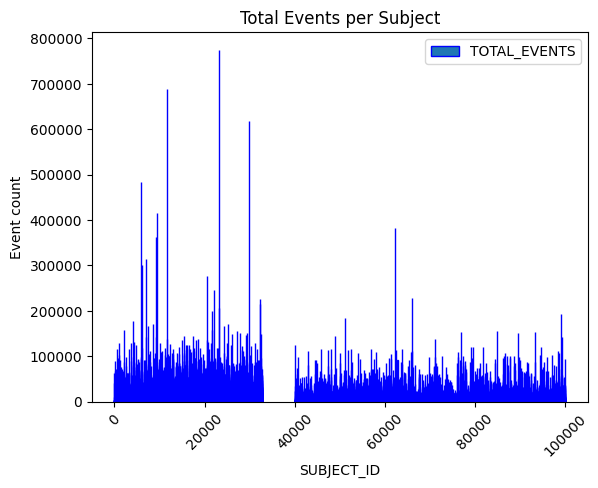

In [21]:
y = [val.TOTAL_EVENTS for val in events_count_df.select('TOTAL_EVENTS').collect()]
x = [val.SUBJECT_ID for val in events_count_df.select('SUBJECT_ID').collect()]

plt.bar(x, y, ec='blue')
plt.ylabel('Event count')
plt.xlabel('SUBJECT_ID')
plt.title('Total Events per Subject')
plt.legend(['TOTAL_EVENTS'], loc='upper right')
plt.xticks(rotation=45) 
plt.show()

Here we can clearly see what looks like an irregularity in the dataset, so let's dive deeper...

In [22]:
filtered_events_count_df = events_count_df.where(col("SUBJECT_ID").between(32810, 40000))
filtered_events_count_df.show(10)

+----------+------------+
|SUBJECT_ID|TOTAL_EVENTS|
+----------+------------+
|     32810|       39128|
|     40000|       16710|
+----------+------------+



We can see here clearly that IDs between 32810 and 40000 arent recorded here, let's try to find why.

In [23]:
filtered_df = df.where(col("SUBJECT_ID").between(32811, 39999))
filtered_df.show(10)

+------+----------+-------+----------+------+---------+---------+----+-----+--------+--------+-------+-----+------------+-------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|CHARTTIME|STORETIME|CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+------+----------+-------+----------+------+---------+---------+----+-----+--------+--------+-------+-----+------------+-------+
+------+----------+-------+----------+------+---------+---------+----+-----+--------+--------+-------+-----+------------+-------+



The IDs dont even exist!
seeing as they aren't even recorded, theres nothing to process and so theres nothing to do.

Since each subject can have multiple admissions, let's also look by admission ID.

In [24]:
events_count_by_admission_df = df.groupBy("HADM_ID").agg(count("*").alias("TOTAL_EVENTS"))
events_count_by_admission_df.describe("TOTAL_EVENTS").show()

+-------+-----------------+
|summary|     TOTAL_EVENTS|
+-------+-----------------+
|  count|            57272|
|   mean|5774.418267216091|
| stddev| 12266.6449584329|
|    min|                1|
|    max|           775024|
+-------+-----------------+



Now there are more events than before, likely the difference comes from hospital admissions that don´t contain a subject id.

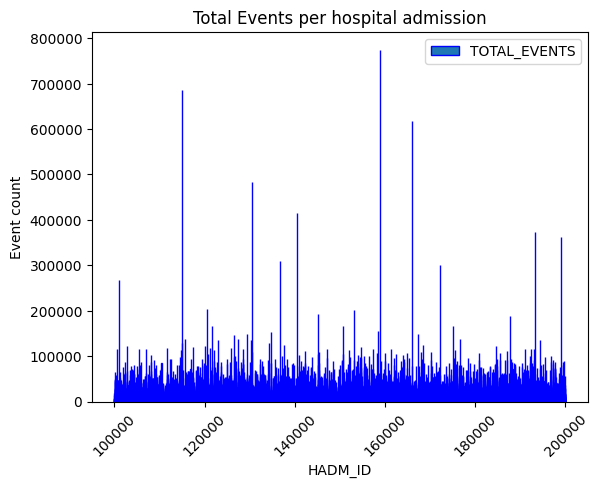

In [25]:
y = [val.TOTAL_EVENTS for val in events_count_by_admission_df.select('TOTAL_EVENTS').collect()]
x = [val.HADM_ID for val in events_count_by_admission_df.select('HADM_ID').collect()]

plt.bar(x, y, ec='blue')
plt.ylabel('Event count')
plt.xlabel('HADM_ID')
plt.title('Total Events per hospital admission')
plt.legend(['TOTAL_EVENTS'], loc='upper right')
plt.xticks(rotation=45) 
plt.show()

### Number of Admissions (NoA)

In [26]:
noa_df = df.groupBy("SUBJECT_ID").agg(countDistinct("HADM_ID").alias("NUMBER_OF_ADMISSIONS"))
noa_df.describe("NUMBER_OF_ADMISSIONS").show()

+-------+--------------------+
|summary|NUMBER_OF_ADMISSIONS|
+-------+--------------------+
|  count|               46467|
|   mean|  1.2325306131232918|
| stddev|  0.8467634142511434|
|    min|                   1|
|    max|                  41|
+-------+--------------------+



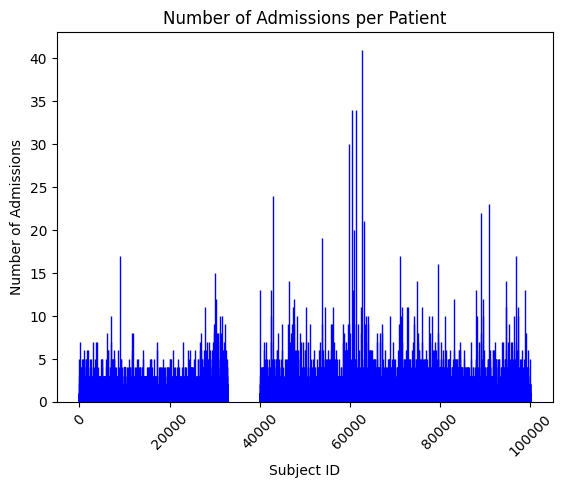

In [27]:
subject_ids = [row.SUBJECT_ID for row in noa_df.select("SUBJECT_ID").collect()]
num_admissions = [row.NUMBER_OF_ADMISSIONS for row in noa_df.select("NUMBER_OF_ADMISSIONS").collect()]

plt.bar(subject_ids, num_admissions, ec='blue') 
plt.ylabel('Number of Admissions')
plt.xlabel('Subject ID')
plt.title('Number of Admissions per Patient')
plt.xticks(rotation=45)
plt.show()

To determine if there is subjects with more than one hospital admission, we do a groupBy operation on the ``SUBJECT_ID`` column and then count the number of unique ``HADM_IDs`` for each ``SUBJECT_ID``. 

We discovered that 6515 patients had more than one hospital admission.

In [28]:
subjects_multiple_admissions_df = noa_df.where(col("NUMBER_OF_ADMISSIONS") > 1)
subjects_multiple_admissions_df.describe("NUMBER_OF_ADMISSIONS").show()

percentage_multiple_admissions = "{:.2f}".format(subjects_multiple_admissions_df.count() / noa_df.count() * 100)

print( "The percentage of patients that had multiple hospital admissions is " + percentage_multiple_admissions + "%")

+-------+--------------------+
|summary|NUMBER_OF_ADMISSIONS|
+-------+--------------------+
|  count|                6515|
|   mean|  2.6584804297774367|
| stddev|    1.65810959886756|
|    min|                   2|
|    max|                  41|
+-------+--------------------+



The percentage of patients that had multiple hospital admissions is 14.02%


To determine if there is subjects with more than one ICU stay, we do a groupBy operation on the ``SUBJECT_ID`` column and then count the number of unique ``ICUSTAY_IDs`` for each ``SUBJECT_ID``. 

We discovered that 8436 patients had more than one ICU stay.

In [29]:
noa_icu_df = df.groupBy("SUBJECT_ID").agg(countDistinct("ICUSTAY_ID").alias("NUM_ICU_STAYS"))

subjects_multiple_icu_stays = noa_icu_df.filter(col("NUM_ICU_STAYS") > 1)
subjects_multiple_icu_stays.describe("NUM_ICU_STAYS").show()

+-------+------------------+
|summary|     NUM_ICU_STAYS|
+-------+------------------+
|  count|              8436|
|   mean|2.7072072072072073|
| stddev|1.6789361311614799|
|    min|                 2|
|    max|                41|
+-------+------------------+



We used the number of hospital admissions to create a binary feature that indicated whether the pacient has been admitted more than once.

In [30]:
noa_df = noa_df.withColumn("MULTIPLE_ADMISSIONS", when(col("NUMBER_OF_ADMISSIONS") > 1, True).otherwise(False))

noa_df.show(10)

+----------+--------------------+-------------------+
|SUBJECT_ID|NUMBER_OF_ADMISSIONS|MULTIPLE_ADMISSIONS|
+----------+--------------------+-------------------+
|     28124|                   1|              false|
|     45011|                   1|              false|
|     40386|                   1|              false|
|     68135|                   2|               true|
|     24663|                   2|               true|
|     31912|                   2|               true|
|     32539|                   1|              false|
|     41890|                   2|               true|
|     49331|                   1|              false|
|     23364|                   3|               true|
+----------+--------------------+-------------------+
only showing top 10 rows



And did the same for the ICU stays.

In [31]:
noa_icu_df = noa_icu_df.withColumn("MULTIPLE_ICU_STAYS", when(col("NUM_ICU_STAYS") > 1, True).otherwise(False))

noa_icu_df.show(10)

+----------+-------------+------------------+
|SUBJECT_ID|NUM_ICU_STAYS|MULTIPLE_ICU_STAYS|
+----------+-------------+------------------+
|     30361|            1|             false|
|     23364|            3|              true|
|     32414|            1|             false|
|     44906|            1|             false|
|     73683|            1|             false|
|     28088|            1|             false|
|     68135|            2|              true|
|     19079|            4|              true|
|     67089|            2|              true|
|     68579|            2|              true|
+----------+-------------+------------------+
only showing top 10 rows



### Patients

In [32]:
df_patients.groupBy("GENDER").count().show()

+------+-----+
|GENDER|count|
+------+-----+
|     F|20399|
|     M|26121|
+------+-----+



$ Percentage_{females} = {20399 \over 20399+26121} \times 100 { \approx 43.85 \%} $

$ Percentage_{males} = {26121 \over 20399+26121} \times 100 { \approx 56.15 \%} $

In [33]:
df_patients.groupBy("EXPIRE_FLAG").count().show()

+-----------+-----+
|EXPIRE_FLAG|count|
+-----------+-----+
|          1|15759|
|          0|30761|
+-----------+-----+



$ Percentage_{death} {15759 \over 15759+30761} \times 100 { \approx 33.88 \%} $

Let's analyze the patients who have died.

In [34]:
expired_patients_df = df_patients.filter(df_patients.EXPIRE_FLAG == 1)

expired_patients_df = expired_patients_df.withColumn("AGE_AT_DEATH", 
    (datediff(col("DOD"), col("DOB")) / 365.25).cast(IntegerType())
)
expired_patients_df.select("AGE_AT_DEATH").describe().show()

+-------+-----------------+
|summary|     AGE_AT_DEATH|
+-------+-----------------+
|  count|            15759|
|   mean|91.48156608921886|
| stddev| 68.9326419427184|
|    min|                0|
|    max|              310|
+-------+-----------------+



There are 300 years old patients!!

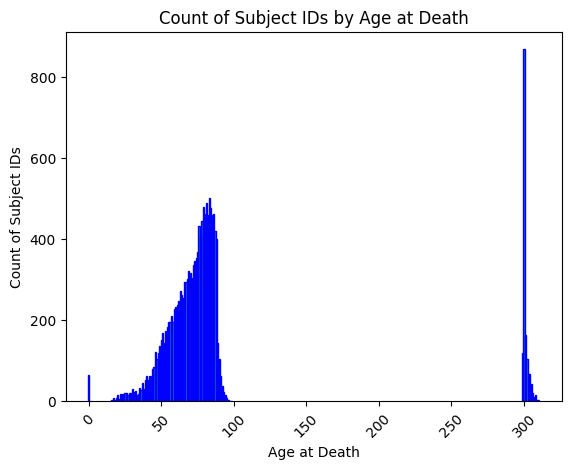

In [35]:
age_counts = expired_patients_df.groupBy("AGE_AT_DEATH").count()
age_counts_data = age_counts.collect()
ages = [row['AGE_AT_DEATH'] for row in age_counts_data]
counts = [row['count'] for row in age_counts_data]

plt.bar(ages, counts, ec='blue')
plt.ylabel('Count of Subject IDs')
plt.xlabel('Age at Death')
plt.title('Count of Subject IDs by Age at Death')
plt.xticks(rotation=45)
plt.show()

For privacy reasons, the date of birth (DOB) of  patients above the age of 89 was shifted.
As stated in the dataset's documentation, "Patients who are older than 89 years old at any time in the database have had their date of birth shifted to obscure their age and comply with HIPAA. The shift process was as follows: the patient’s age at their first admission was determined. The date of birth was then set to exactly 300 years before their first admission."

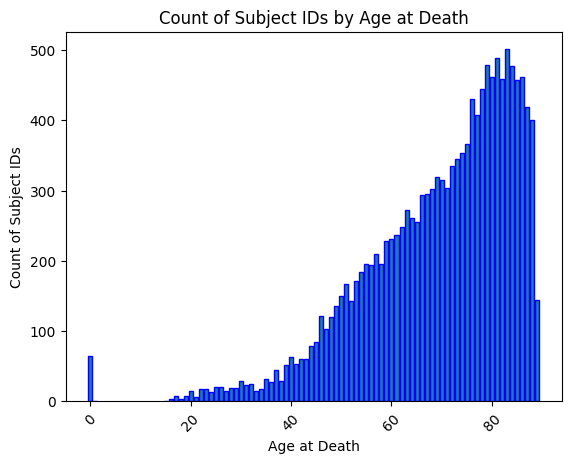

In [36]:
expired_patients_filtered = expired_patients_df.filter(col("AGE_AT_DEATH") <= 89)
age_counts = expired_patients_filtered.groupBy("AGE_AT_DEATH").count()
age_counts_data = age_counts.collect()
ages = [row['AGE_AT_DEATH'] for row in age_counts_data]
counts = [row['count'] for row in age_counts_data]

plt.bar(ages, counts, ec='blue')
plt.ylabel('Count of Subject IDs')
plt.xlabel('Age at Death')
plt.title('Count of Subject IDs by Age at Death')
plt.xticks(rotation=45)
plt.show()

It is impossible to determine the real age of these patients. Therefore, we have decided to remove them.

In [37]:
expired_patients_df = expired_patients_filtered

Now, with the remaining patients that have a valid date of birth we are going to compute their age at the time of admission.

In [38]:
unexpired_patients_df = df_patients.filter(df_patients.EXPIRE_FLAG != 1)

In [39]:
valid_dob_patients_df = expired_patients_df[["ROW_ID", "SUBJECT_ID", "GENDER", "DOB", "DOD", "DOD_HOSP", "DOD_SSN", "EXPIRE_FLAG"]].union(unexpired_patients_df)

df_admissions_with_ages = df_admissions.join(valid_dob_patients_df["SUBJECT_ID","DOB"],on="SUBJECT_ID",how="left")

df_admissions_with_ages = df_admissions_with_ages.withColumn("AGE_AT_ADMISSION", (datediff(col("ADMITTIME"), col("DOB")) / 365.25).cast(IntegerType()))

df_admissions_with_ages.show(10)

+----------+------+-------+-------------------+-------------------+-------------------+--------------+--------------------+--------------------+---------+--------+-----------------+--------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+----------------+
|SUBJECT_ID|ROW_ID|HADM_ID|          ADMITTIME|          DISCHTIME|          DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|  DISCHARGE_LOCATION|INSURANCE|LANGUAGE|         RELIGION|MARITAL_STATUS|           ETHNICITY|          EDREGTIME|          EDOUTTIME|           DIAGNOSIS|HOSPITAL_EXPIRE_FLAG|HAS_CHARTEVENTS_DATA|                DOB|AGE_AT_ADMISSION|
+----------+------+-------+-------------------+-------------------+-------------------+--------------+--------------------+--------------------+---------+--------+-----------------+--------------+--------------------+-------------------+-------------------+--------------------+------

For the remaining patients it is impossible to calculate their age, and we have decided agaisn't methods such as mean imputation.

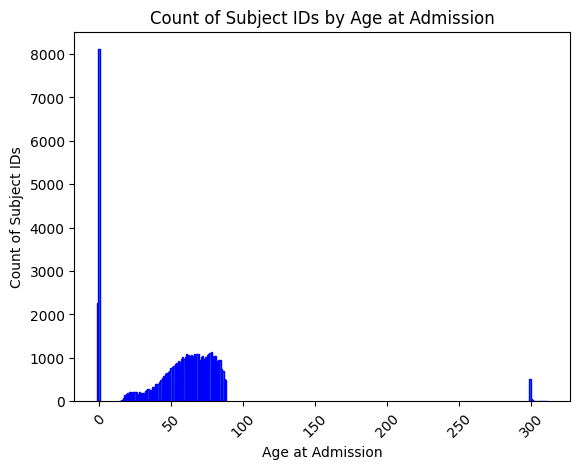

In [40]:
df_admissions_with_ages = df_admissions_with_ages.fillna({'AGE_AT_ADMISSION': -1})

age_counts = df_admissions_with_ages.groupBy("AGE_AT_ADMISSION").count()
age_counts_data = age_counts.collect()
ages = [row['AGE_AT_ADMISSION'] for row in age_counts_data]
counts = [row['count'] for row in age_counts_data]

plt.bar(ages, counts, ec='blue')
plt.ylabel('Count of Subject IDs')
plt.xlabel('Age at Admission')
plt.title('Count of Subject IDs by Age at Admission')
plt.xticks(rotation=45)
plt.show()

A few more still exist among the non-hospital deaths, so we´ll  remove them aswell.

In [41]:
df_admissions_with_ages = df_admissions_with_ages.filter( (col("AGE_AT_ADMISSION") <= 89 ) & ( col("AGE_AT_ADMISSION") >=0  )) 

In [42]:
df_admissions_with_ages.select("AGE_AT_ADMISSION").describe().show()

+-------+-----------------+
|summary| AGE_AT_ADMISSION|
+-------+-----------------+
|  count|            56081|
|   mean|52.87803355860274|
| stddev|26.58217541402827|
|    min|                0|
|    max|               88|
+-------+-----------------+



### Diagnosis

Here, we fill the missing values in the `ICD9_CODE` column with 'NA' so that they can be analyzed correctly. Then, we group the data by `ICD9_CODE` and count the occurrences of each code.

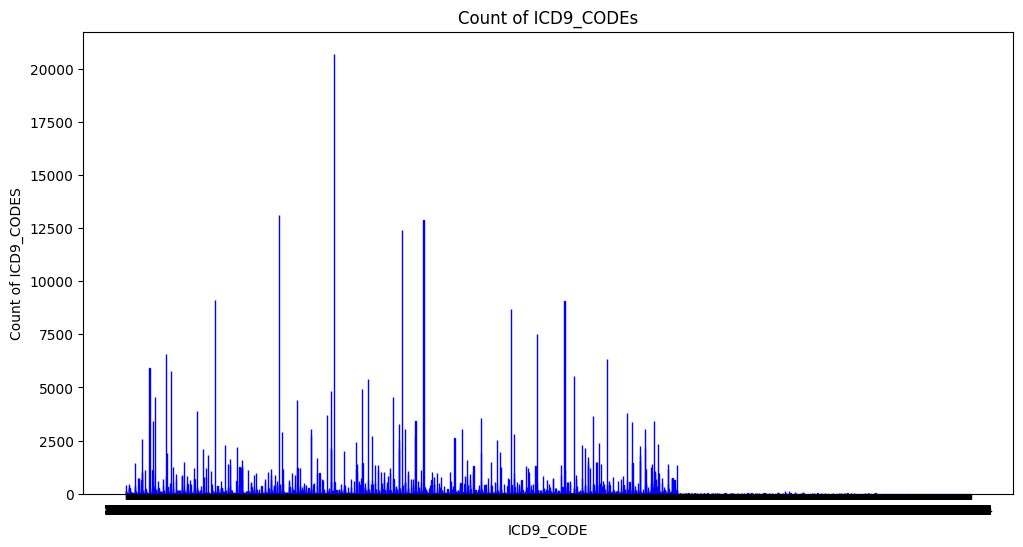

In [70]:
df_icd_diagnoses = df_icd_diagnoses.fillna({'ICD9_CODE': 'NA'})
icd9_code_counts = df_icd_diagnoses.groupBy("ICD9_CODE").count()
icd9_code_counts_data = icd9_code_counts.collect()

icd9_codes = [row['ICD9_CODE'] for row in icd9_code_counts_data]
counts = [row['count'] for row in icd9_code_counts_data]

plt.figure(figsize=(12, 6))
plt.bar(icd9_codes, counts, ec='blue')
plt.ylabel('Count of ICD9_CODES')
plt.xlabel('ICD9_CODE')
plt.title('Count of ICD9_CODEs')
plt.show()

We join `icd9_code_counts` with `df_d_icd_diagnoses` to to find out which disease each `ICD9_CODE` corresponds.

In [45]:
icd9_code_counts = icd9_code_counts.join(df_d_icd_diagnoses, on='ICD9_CODE', how='left')
icd9_code_counts.show(5)

+---------+-----+------+--------------------+--------------------+
|ICD9_CODE|count|ROW_ID|         SHORT_TITLE|          LONG_TITLE|
+---------+-----+------+--------------------+--------------------+
|     4821|  430|  5502|Pseudomonal pneum...|Pneumonia due to ...|
|    55321|  152|  5556|   Incisional hernia|Incisional hernia...|
|     0579|    3|   971|Viral exanthemata...|Viral exanthem, u...|
|    85405|   10|  8848|Brain inj NEC-dee...|Intracranial inju...|
|    70721|  121|  8127|Pressure ulcer, s...|Pressure ulcer, s...|
+---------+-----+------+--------------------+--------------------+
only showing top 5 rows



Summary statistics:

In [46]:
total_unique_codes = icd9_code_counts.select("ICD9_CODE").distinct().count()
total_subject_ids = icd9_code_counts.select(spark_sum("count")).first()[0]
min_count = icd9_code_counts.select(spark_min("count")).first()[0]
max_count = icd9_code_counts.select(spark_max("count")).first()[0]
average_count = icd9_code_counts.select(spark_avg("count")).first()[0]
top_five_diseases = icd9_code_counts.orderBy(desc("count")).limit(5)
five_least_frequent_diseases = icd9_code_counts.orderBy(asc("count")).limit(5)

print(f"Total number of unique ICD9 codes: {total_unique_codes}")
print(f"Total count of subject IDs: {total_subject_ids}")
print(f"Minimum count: {min_count}")
print(f"Maximum count: {max_count}")
print(f"Average count: {average_count:.2f}")
print("5 most frequent deseases (short title):")
top_five_diseases["SHORT_TITLE","count"].show(truncate=False)
print("5 least frequent deseases (short title):")
five_least_frequent_diseases["SHORT_TITLE","count"].show(truncate=False)

Total number of unique ICD9 codes: 6985
Total count of subject IDs: 651047
Minimum count: 1
Maximum count: 20703
Average count: 93.21
5 most frequent deseases (short title):
+------------------------+-----+
|SHORT_TITLE             |count|
+------------------------+-----+
|Hypertension NOS        |20703|
|CHF NOS                 |13111|
|Atrial fibrillation     |12891|
|Crnry athrscl natve vssl|12429|
|Acute kidney failure NOS|9119 |
+------------------------+-----+

5 least frequent deseases (short title):
+------------------------+-----+
|SHORT_TITLE             |count|
+------------------------+-----+
|Prog muscular atrophy   |1    |
|Benign neo skin eyelid  |1    |
|Hyperem w metab-antepart|1    |
|Schizoaff dis-subch/exac|1    |
|Anomalies of inner ear  |1    |
+------------------------+-----+



Let's find the code of the most common diagnosis.

In [47]:
df_d_icd_diagnoses.filter(col("SHORT_TITLE") == lit("Hypertension NOS")).show()

+------+---------+----------------+--------------------+
|ROW_ID|ICD9_CODE|     SHORT_TITLE|          LONG_TITLE|
+------+---------+----------------+--------------------+
|  4304|     4019|Hypertension NOS|Unspecified essen...|
+------+---------+----------------+--------------------+



There are 47 patients without a diagnostic.

In [48]:
icd9_code_counts_null = icd9_code_counts.filter(col("ICD9_CODE") == "NA")
icd9_code_counts_null.show()

+---------+-----+------+-----------+----------+
|ICD9_CODE|count|ROW_ID|SHORT_TITLE|LONG_TITLE|
+---------+-----+------+-----------+----------+
|       NA|   47|  NULL|       NULL|      NULL|
+---------+-----+------+-----------+----------+



## LOS Predictions

### Constructing the model's dataset

Getting the base set of IDs and the target variable.

In [49]:
ds = df_icustays[["HADM_ID", "SUBJECT_ID", "LOS"]]

Filter to include only the most common diagnosis and adding corresponding sequence number for that particular admission.

In [50]:
ds = ds.join(df_icd_diagnoses[["SUBJECT_ID", "HADM_ID", "SEQ_NUM", "ICD9_CODE"]].filter(col("ICD9_CODE") == "4019"),on=["HADM_ID", "SUBJECT_ID"], how="inner" )

~~Add the min max and average values to each patient.~~  
We wanted to use these values, but the way they are presently formatted makes this hard.
We thought about deriving a score, based on the item's severity and quantity and dosage, but our lack of medical expertise makes this tough.  
Perhaps if this dataset came bundled with a doctor...

In [51]:
#ds = ds.join(item_df[["HADM_ID", "SUBJECT_ID", "min_value", "max_value", "avg_value"]],on=["HADM_ID", "SUBJECT_ID"], how="left" )

Adding the event count to each admission.

In [52]:
ds = ds.join(events_count_by_admission_df[["HADM_ID","TOTAL_EVENTS"]],on=["HADM_ID"], how="inner")

And the gender.

In [53]:
ds = ds.join(df_patients[["SUBJECT_ID","GENDER"]],on=["SUBJECT_ID"], how="inner") 

And whether or not they have been admitted to the hospital multiple times.

In [54]:
ds = ds.join(noa_df[["SUBJECT_ID","MULTIPLE_ADMISSIONS"]],on=["SUBJECT_ID"], how="inner") 

The same but for the ICU.

In [55]:
ds = ds.join(noa_icu_df[["SUBJECT_ID","MULTIPLE_ICU_STAYS"]],on=["SUBJECT_ID"], how="inner") 

Finally, the age at admission and admission type and admission date if we decide we want to order the window by date of entry.

In [56]:
ds = ds.join(df_admissions_with_ages[["SUBJECT_ID", "HADM_ID","ADMISSION_TYPE","AGE_AT_ADMISSION","ADMITTIME"]],on=["SUBJECT_ID", "HADM_ID"], how="inner") 

We shouldn't need this code anymore...

In [57]:
ds = ds.drop("ICD9_CODE")

We use `StringIndexer` to convert categorical string columns into numeric indices. This is crucial for ML models that require numerical input.

In [58]:
indexer = StringIndexer(inputCol="GENDER", outputCol="GENDER_INDEX") 
ds = indexer.fit(ds).transform(ds) 

indexer = StringIndexer(inputCol="ADMISSION_TYPE", outputCol="ADMISSION_TYPE_INDEX") 
ds = indexer.fit(ds).transform(ds) 

ds = ds.withColumn("MULTIPLE_ADMISSIONS_INDEX", when(col("MULTIPLE_ADMISSIONS") == True, 1).otherwise(0))

ds = ds.withColumn("MULTIPLE_ICU_STAYS_INDEX", when(col("MULTIPLE_ICU_STAYS") == True, 1).otherwise(0))

'''
ds = ds.withColumn('admit_weekday', dayofweek('ADMITTIME'))
ds = ds.withColumn('admit_day', dayofmonth('ADMITTIME'))
ds = ds.withColumn('admit_month', month('ADMITTIME'))
ds = ds.withColumn('admit_year', year('ADMITTIME'))
ds = ds.withColumn('admit_hour', hour('ADMITTIME'))
'''

ds = ds.drop("GENDER", "ADMISSION_TYPE", "MULTIPLE_ADMISSIONS", "MULTIPLE_ICU_STAYS")

ds = ds.withColumnRenamed("GENDER_INDEX", "GENDER")
ds = ds.withColumnRenamed("ADMISSION_TYPE_INDEX", "ADMISSION_TYPE")
ds = ds.withColumnRenamed("MULTIPLE_ADMISSIONS_INDEX", "MULTIPLE_ADMISSIONS")
ds = ds.withColumnRenamed("MULTIPLE_ICU_STAYS_INDEX", "MULTIPLE_ICU_STAYS")

ds.show(5)

+----------+-------+------+-------+------------+----------------+-------------------+------+--------------+-------------------+------------------+
|SUBJECT_ID|HADM_ID|   LOS|SEQ_NUM|TOTAL_EVENTS|AGE_AT_ADMISSION|          ADMITTIME|GENDER|ADMISSION_TYPE|MULTIPLE_ADMISSIONS|MULTIPLE_ICU_STAYS|
+----------+-------+------+-------+------------+----------------+-------------------+------+--------------+-------------------+------------------+
|       295| 192988|0.9057|      2|        1246|              61|2176-03-06 12:30:00|   1.0|           1.0|                  0|                 0|
|      2791| 160235|1.3653|      4|         732|              74|2120-04-25 17:04:00|   1.0|           0.0|                  1|                 1|
|      2556| 135423| 0.705|      9|         736|              62|2173-02-20 23:57:00|   0.0|           0.0|                  0|                 0|
|      4496| 144907|1.4628|      5|        1446|              69|2165-09-23 13:59:00|   0.0|           0.0|           

Now let's do a correlation matrix.

24/06/21 16:35:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/21 16:35:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


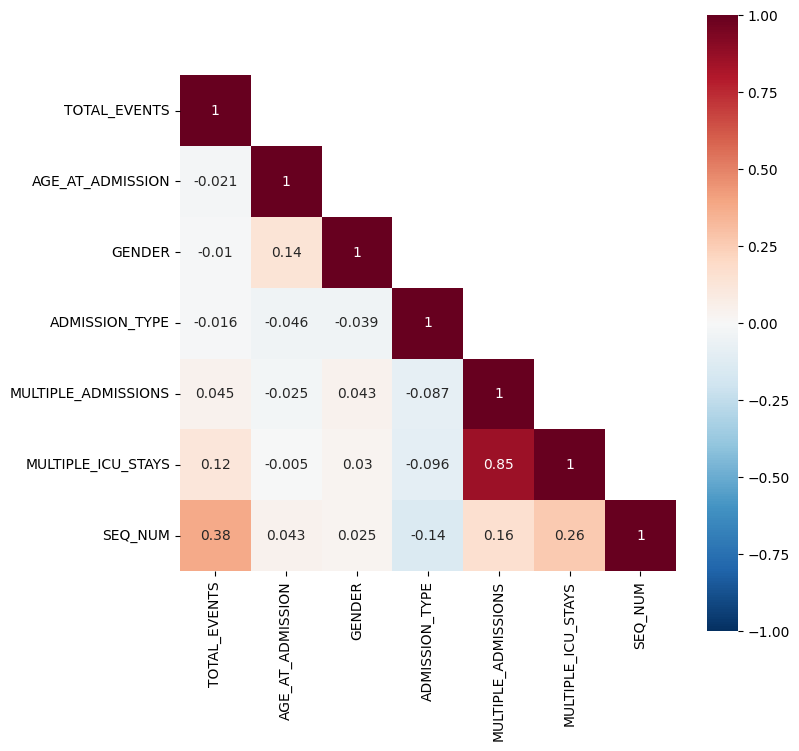

In [59]:
feature_columns = ["TOTAL_EVENTS", "AGE_AT_ADMISSION", "GENDER", "ADMISSION_TYPE", "MULTIPLE_ADMISSIONS", "MULTIPLE_ICU_STAYS", "SEQ_NUM"]

vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
vector_df = vector_assembler.transform(ds).select("features")

correlation_matrix = Correlation.corr(vector_df, "features").head()[0]

corr_matrix_array = np.array(correlation_matrix.toArray())

corr_matrix_df = pd.DataFrame(corr_matrix_array, index=feature_columns, columns=feature_columns)

mask = np.tri(corr_matrix_df.shape[0], dtype=bool)

plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix_df, mask=~mask, cmap='RdBu_r', square=True, vmin=-1, vmax=1, annot=True)
plt.show()

Overall the only significative correlation was more or less expected.  
There's also a surprising correlation but not as significant correlation in `SEQ_NUM` and `TOTAL_EVENTS`.

### Null Values

There are no null values.

In [60]:
ds.select([count(when(isnull(c), c)).alias(c) for c in ds.columns]).show()

+----------+-------+---+-------+------------+----------------+---------+------+--------------+-------------------+------------------+
|SUBJECT_ID|HADM_ID|LOS|SEQ_NUM|TOTAL_EVENTS|AGE_AT_ADMISSION|ADMITTIME|GENDER|ADMISSION_TYPE|MULTIPLE_ADMISSIONS|MULTIPLE_ICU_STAYS|
+----------+-------+---+-------+------------+----------------+---------+------+--------------+-------------------+------------------+
|         0|      0|  0|      0|           0|               0|        0|     0|             0|                  0|                 0|
+----------+-------+---+-------+------------+----------------+---------+------+--------------+-------------------+------------------+



### Duplicate Values

There are no duplicates in the dataset.

In [61]:
duplicate_cols = ['HADM_ID', 'SUBJECT_ID', 'LOS', 'SEQ_NUM', 'TOTAL_EVENTS', 'MULTIPLE_ADMISSIONS', 'MULTIPLE_ICU_STAYS', 'AGE_AT_ADMISSION', 'ADMITTIME', 'GENDER', 'ADMISSION_TYPE']
ds.groupBy(duplicate_cols)\
    .count()\
    .where(col('count') > 1)\
    .select(sum('count'))\
    .show()

+----------+
|sum(count)|
+----------+
|      NULL|
+----------+



### Outliers

As we can see from the box plot, the dataset has some outliers.

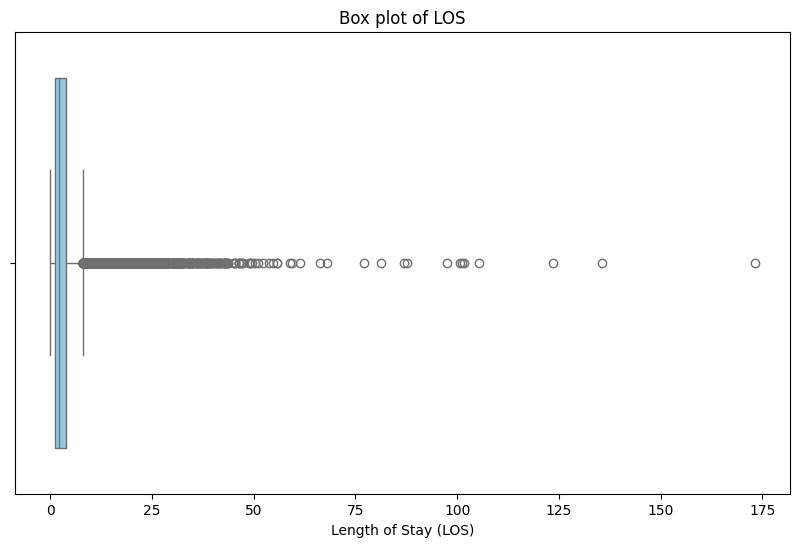

In [62]:
ds_pandas = ds.select('LOS').toPandas()

plt.figure(figsize=(10, 6))
sns.boxplot(x='LOS', data=ds_pandas, whis=1.5, showfliers=True, color='skyblue')
plt.title('Box plot of LOS')
plt.xlabel('Length of Stay (LOS)')
plt.show()

We decided to remove the `LOS`s greater than 75. 

In [63]:
ds = ds.filter(ds['LOS'] <= 75)
ds.describe('LOS').show()

+-------+-----------------+
|summary|              LOS|
+-------+-----------------+
|  count|            19891|
|   mean|3.747975958976439|
| stddev|5.056071571607134|
|    min|           3.0E-4|
|    max|          67.9735|
+-------+-----------------+



Looks good, let's save it as a parquet file, so we can hop over to the ML task notebook.

In [64]:
ds_parquet_file_path = "dataset/DS.parquet"

ds.write.format("parquet") \
    .option("compression", "snappy") \
    .save(ds_parquet_file_path)